## Agustina Setianing Budi_Insight

## Prediksi Harga Saha dengan metode Long Short Therm Memory (LSTM)

### Tahap 1 Import Library

In [1]:
from __future__ import print_function
import os
import math
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa import stattools
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

### Tahap 2 Data Understanding

Mengimport dataset yang akan digunakan dalam hal ini saham yang akan di analisis adalah saham PT Tekom Indonesia (Persero) Tbk 

In [2]:
#Import Data
df = pd.read_csv("TLKM.JK1.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0
5,2017-01-09,4000.0,4030.0,3990.0,4020.0,3343.399414,85713200.0
6,2017-01-10,4030.0,4030.0,3960.0,4000.0,3326.765381,44608000.0
7,2017-01-11,3960.0,4000.0,3950.0,3960.0,3293.497559,47226300.0
8,2017-01-12,3920.0,3970.0,3920.0,3960.0,3293.497559,45738500.0
9,2017-01-13,3930.0,3970.0,3930.0,3950.0,3285.180664,64704600.0


In [3]:
# Memunculkan Jumlah total data dan renge tanggal dataset
print("Total Data : {} \n".format(len(df)))
print("Date range from : {} to {}".format(df.head(1)['Date'].values, df.tail(1)['Date'].values))

Total Data : 1422 

Date range from : ['2017-01-02'] to ['2022-09-01']


In [4]:
# Menampilkan informasi umum mengenai dataset yang digunakakn
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1422 non-null   object 
 1   Open       1421 non-null   float64
 2   High       1421 non-null   float64
 3   Low        1421 non-null   float64
 4   Close      1421 non-null   float64
 5   Adj Close  1421 non-null   float64
 6   Volume     1421 non-null   float64
dtypes: float64(6), object(1)
memory usage: 77.9+ KB


In [5]:
# Cek nilai "NaN" Pada kolom 
null_columns=df.columns[df.isnull().any()]
print(df[df["Open"].isnull()][null_columns])

     Open  High  Low  Close  Adj Close  Volume
636   NaN   NaN  NaN    NaN        NaN     NaN


Terdapat nilai 'Nan' pada dataset. Berarti terdapat nilai yang tidak diketahui pada dataset. Terdapat 636 daya dengan nilai 'Nan" dari total 1422. Karena terdapapt nilai Nan maka akan dihapus, karena tidak dibutuhkan.

In [6]:
# melakukan penghapusan NaN
df = df.drop([636])
df.reset_index(drop=True,inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0


In [7]:
# pendeskripsian data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1.421000e+03
mean,3827.741027,3869.106263,3785.608726,3827.171006,3416.287764,1.021061e+08
std,490.449096,487.302987,492.470774,492.369542,462.616891,6.629501e+07
min,2550.000000,2590.000000,2450.000000,2560.000000,2289.641846,0.000000e+00
25%,3450.000000,3490.000000,3400.000000,3450.000000,3111.957031,6.168190e+07
50%,3870.000000,3900.000000,3840.000000,3870.000000,3357.914063,8.730300e+07
75%,4190.000000,4220.000000,4150.000000,4190.000000,3708.230957,1.234112e+08
max,4850.000000,4850.000000,4780.000000,4800.000000,4750.000000,6.241426e+08


In [8]:
# menampilkan data tanggal dan close 
data = df[['Date', 'Close']]
data.head(10)

,Date,Close
0,2017-01-02,3980.0
1,2017-01-03,3950.0
2,2017-01-04,3950.0
3,2017-01-05,3950.0
4,2017-01-06,4000.0
5,2017-01-09,4020.0
6,2017-01-10,4000.0
7,2017-01-11,3960.0
8,2017-01-12,3960.0
9,2017-01-13,3950.0


Perlu dilakukan perubahan untuk column "Date" dari objectstring menjadi dateformat. perubahan dilakaukan karena data yang ingin dilihat adalah perkembangan harga dari tahun ke tahin, bukkan hari ke hari. 

In [9]:
# mengubah 'Date' menjadi datetime
data.index = data['Date'].map(lambda d: pd.to_datetime(d, format = '%Y-%m-%d'))
data.drop('Date',axis=1, inplace=True)
data.head(10)

,Close
Date,
2017-01-02,3980.0
2017-01-03,3950.0
2017-01-04,3950.0
2017-01-05,3950.0
2017-01-06,4000.0
2017-01-09,4020.0
2017-01-10,4000.0
2017-01-11,3960.0
2017-01-12,3960.0


Dalam proses data understanding, visualisasi yang digunakan berupa grafik karena memudahkan untuk mengetahhui perkembangan harga saham TLKM dari datased dan periode yang ada.

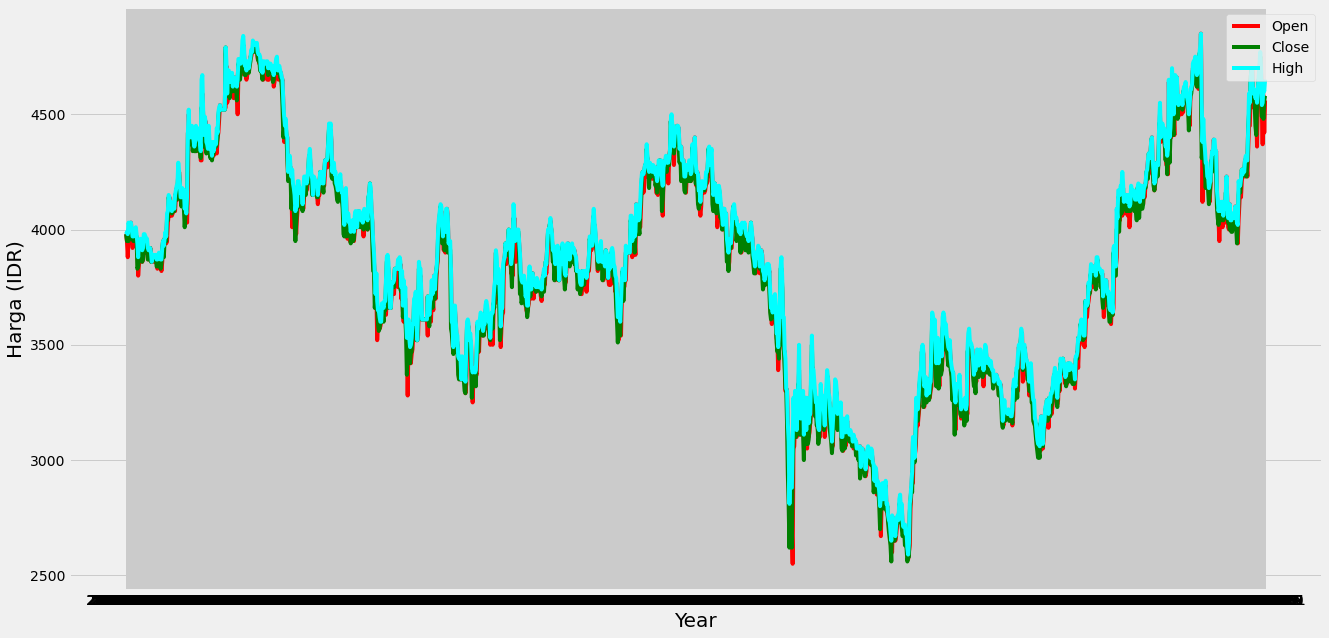

In [10]:
visual_plot =df[['Date','Close', 'Open', 'High']]

plt.figure(figsize=(20,10))

sns.lineplot(y=visual_plot['Open'], color="r", x=visual_plot['Date'])
sns.lineplot(y=visual_plot['Close'], color="g", x=visual_plot['Date'])
sns.lineplot(y=visual_plot['High'], color="cyan", x=visual_plot['Date'])

plt.xlabel('Year', fontsize=20)
plt.ylabel('Harga (IDR)', fontsize=20)
plt.legend(['Open','Close','High'], loc='upper right')

### Tahap 3 Data preparation

Pertama melekukan pengecekan terhdap data apakah dataset aman dari missing value dan Duplikasi (tidak terdapat duplikasi).

In [11]:
# Menampilkan Missing Value (n.a)
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
# Mengecek duplikasi
check_duplicates = df[df.duplicated()]
print(check_duplicates)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


Setelah dilakukan pengecekan missing value dan duplikasi, keduanya tidak ditemukan pada dataset.

In [13]:
data = data.filter(['Close'])
dataset = data.values

#menghitung jumlah baris yang dilatih.
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

1137

In [14]:
#mengukur data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.63392857],
       [0.62053571],
       [0.62053571],
       ...,
       [0.85714286],
       [0.89285714],
       [0.90178571]])

In [15]:
#membuat dataset latih
#membuat scaled dataset
train_data = scaled_data[0:training_data_len , :]
#membagi data ke x_train dan y_train dataset
x_train = []
y_train = []
for i in range(80, len(train_data)):
    x_train.append(train_data[i-80:i, 0])
    y_train.append(train_data[i,0])
    if i<=80:
        print(x_train)
        print(y_train)
        print()

[array([0.63392857, 0.62053571, 0.62053571, 0.62053571, 0.64285714,
       0.65178571, 0.64285714, 0.625     , 0.625     , 0.62053571,
       0.62053571, 0.62946429, 0.625     , 0.62946429, 0.56696429,
       0.57142857, 0.60267857, 0.59821429, 0.61607143, 0.59375   ,
       0.58035714, 0.58482143, 0.61607143, 0.62053571, 0.62053571,
       0.625     , 0.60714286, 0.58482143, 0.58482143, 0.59375   ,
       0.60714286, 0.58035714, 0.58035714, 0.58482143, 0.58482143,
       0.58482143, 0.58928571, 0.58928571, 0.57142857, 0.57142857,
       0.58482143, 0.57589286, 0.57589286, 0.56696429, 0.57589286,
       0.60714286, 0.62053571, 0.58928571, 0.625     , 0.62053571,
       0.62053571, 0.66517857, 0.66071429, 0.70535714, 0.69196429,
       0.6875    , 0.68303571, 0.67410714, 0.68303571, 0.67857143,
       0.67857143, 0.70982143, 0.70535714, 0.70089286, 0.71875   ,
       0.75446429, 0.75446429, 0.71875   , 0.70089286, 0.6875    ,
       0.70982143, 0.70982143, 0.68303571, 0.64732143, 0.6741

In [16]:
#menghubah x_train dan y_train ke dlan numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
#reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1057, 80, 1)

### Tahap 4 Arsitektur Model

Penggunaan LSTM sebagai input layer dan Dense sebagai output layer

In [18]:
#membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(1))

Menggunakan MAE metrics dan MSE sebagai loss function

In [19]:
#Menyusun model
model.compile(optimizer='adam', loss='mean_squared_error')

### Tahap 5 Model Training Untuk Deep Learning

In [20]:
#Melatih/Train model 
model.fit(x_train, y_train, batch_size=1, epochs=1)

1057/1057 [==============================] - 37s 31ms/step - loss: 0.0050


In [21]:
#Membuat Testing Dataset
#Membuat New array yang terdiri dari 'scaled dataset' dari indes 1501 sampai dengan 1975
test_data = scaled_data[training_data_len - 80: , :]

#Membentuk dataset x_test dan y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(80, len(test_data)):
    x_test.append(test_data[i-80:i, 0])
    

In [22]:
#Mengubah data ke bentuk numypy array
x_test = np.array(x_test)

In [23]:
#Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [24]:
#membuat model prediksi harga
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

9/9 [==============================] - 1s 21ms/step


In [25]:
#Menampilkan hasil root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

36.90414815553477

In [26]:
# menampilkan real data 
data

,Close
Date,
2017-01-02,3980.0
2017-01-03,3950.0
2017-01-04,3950.0
2017-01-05,3950.0
2017-01-06,4000.0
...,...
2022-08-26,4490.0
2022-08-29,4520.0
2022-08-30,4480.0


### Tahap 6 Model Prediction

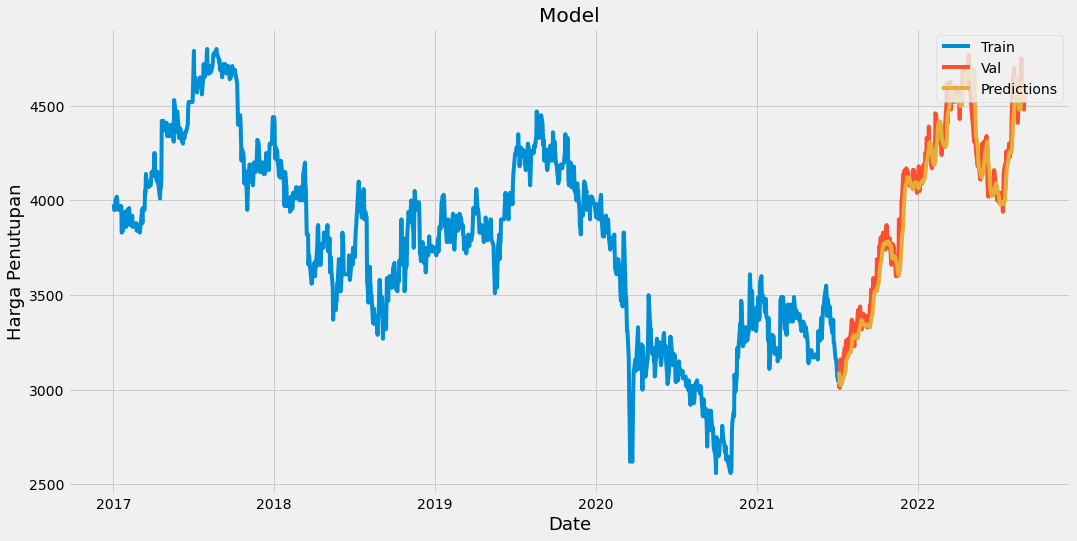

In [27]:
#Melakukan plot Data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Memvisualisasi data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Harga Penutupan', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

### Kesimpulan

Dapat dilihat pada plot data tersebut, garis biru menunjukan hasil data model yang dilatih. Warna orange merupakan nilai aktual untuk sisa hari selanjutnya. dan warna kunigng menunjukan adalah predksi yang dihasilkan melalui model yang telah dibuat. pada garis orange dan kuning, jaraknya sangat dekat yang mengartikan bahwa model yang dibuat cukup baik untuk melakukan prediksi harga.